given a library of midi loops, meander through it, always playing the most similar unplayed loop


## functions


In [1]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    bar_length = 100
    # decimals = 1
    # percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    percent = f"{iteration:.2f}/{total:.2f}"
    filledLength = int(bar_length * iteration // total)
    bar = fill * filledLength + '-' * (bar_length - filledLength)
    print(f'\r{prefix} |{bar}| {percent} {suffix}', end = printEnd)

    if iteration == total: 
        print()

In [2]:
import mido
import pretty_midi

def normalize_midi(mid: pretty_midi.PrettyMIDI):
  """Normalize MIDI file so that the first note is at 0.0s."""
  for instrument in mid.instruments:
    if not instrument.notes:
      continue
    first_note_start = instrument.notes[0].start
    for note in instrument.notes:
      note.start -= first_note_start
      note.end -= first_note_start
  return mid

In [3]:
from scipy.spatial.distance import cosine

def find_most_similar_vector(target_vector, vector_array):
  most_similar_vector = None
  highest_similarity = -1  # since cosine similarity ranges from -1 to 1

  for vector_data in vector_array:
    name, vector = vector_data.values()
    similarity = 1 - cosine(target_vector, vector)  # type: ignore
    if similarity > highest_similarity:
      highest_similarity = similarity
      most_similar_vector = name

  return most_similar_vector

In [4]:
def play_midi_file(midi_data: mido.MidiFile, midi_port):
  t = 0
  for msg in midi_data.play():
    printProgressBar(t, midi_data.length, suffix='s')
    t += msg.time # type: ignore
    midi_port.send(msg)
  printProgressBar(midi_data.length, midi_data.length, suffix='s')

## calculate metrics


In [5]:
import os
import midi_utils as cu
from IPython import display

midi_metrics = {}
# folder_path = os.path.join("data", "outputs", "MIDI3")
folder_path = os.path.join("data", "outputs", "time", "MIDI4-shifted")
config = {"w1": 0.5, "w2": 0.5, "bin_length": 1.0}

for file in os.listdir(folder_path):
  if file.endswith('.mid') or file.endswith('.midi'):
    file_path = os.path.join(folder_path, file)
    midi = pretty_midi.PrettyMIDI(file_path)

    normalized_midi = normalize_midi(midi)
    metrics = cu.all_metrics(midi, config)

    midi_metrics[file] = {
      # "notes": normalized_midi,
      "metrics": metrics,
      "played": 0,
    }

In [6]:
import json

dict_file = os.path.join("data", "outputs", "midi_metrics.json")

with open(dict_file, 'w') as f:
  json.dump(midi_metrics, f)

## play


[29.31/6000.00]	Playing MIDI4-shifted-23.mid 	(next up is MIDI4-shifted-2.mid)


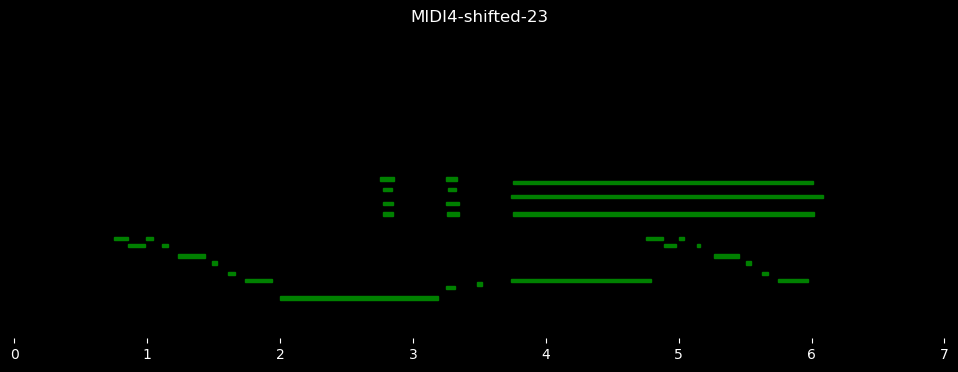

KeyboardInterrupt: 

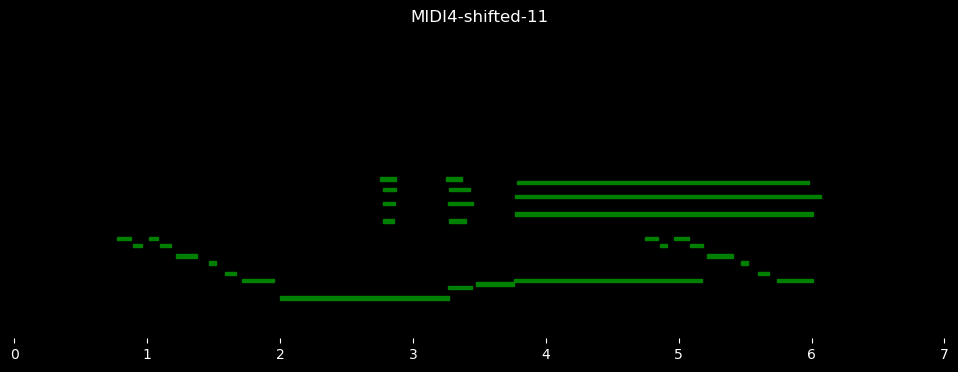

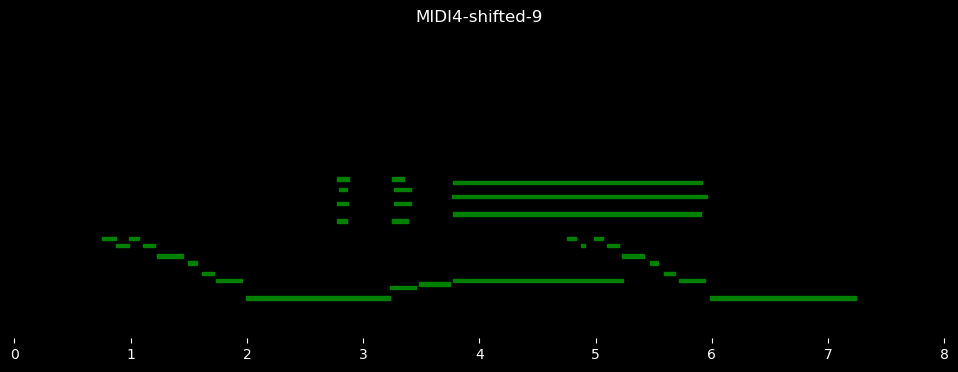

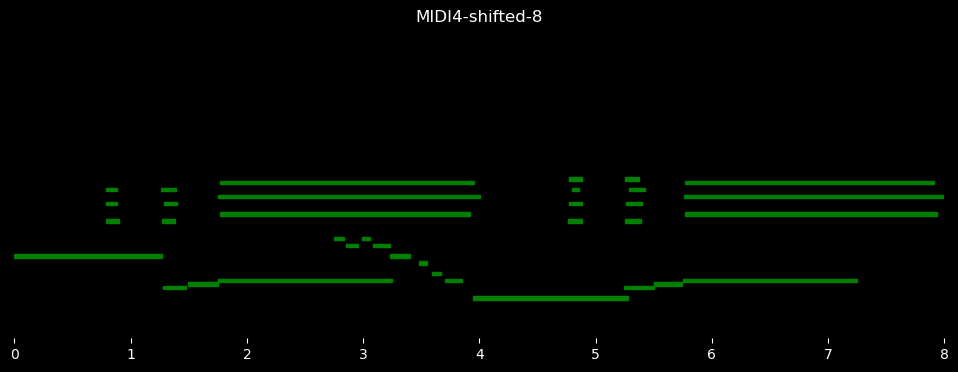

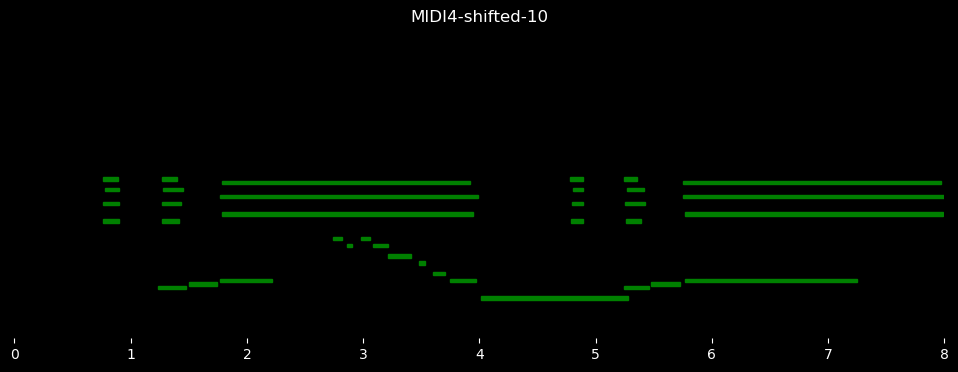

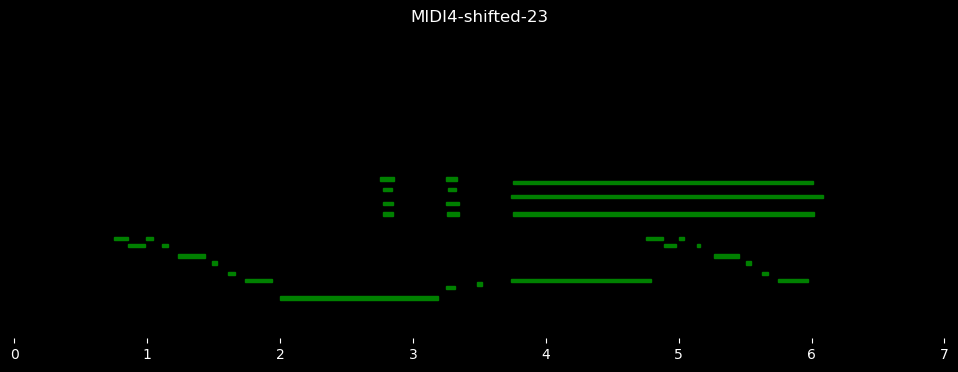

In [7]:
import time
import numpy as np
from midi_utils import draw_midi

loop_chance = 0.0 # pct
play_time = 6000 # seconds
time_elapsed = 0 # seconds
loop_time = 6.0 # seconds
midi_device_name = "to Max 1"
seed = np.random.randint(0, len(midi_metrics.items()) - 1)
current_file_path = list(midi_metrics.items())[seed][0] # choose random initial file
next_file_path = None
port = mido.open_output(midi_device_name) # type: ignore

while (time_elapsed < play_time):
  midi_metrics[current_file_path]['played'] = True

  # find next file
  if (np.random.rand() > loop_chance):
    cph = list(midi_metrics.items())[seed][1]['metrics']['pitch_histogram']
    all_vecs = [
      {'name': filename, 'metric': details['metrics']['pitch_histogram']}
      for filename, details in midi_metrics.items()
      if not details['played']
    ]
    next_file_path = find_most_similar_vector(cph, all_vecs)
  else:
    next_file_path = current_file_path
  print(f"[{time_elapsed:.2f}/{play_time:.2f}]\tPlaying {current_file_path} \t(next up is {next_file_path})")

  # play file
  midi = mido.MidiFile(os.path.join(folder_path, current_file_path)) # type: ignore
  time_elapsed += midi.length
  display.display(draw_midi(os.path.join(folder_path, current_file_path))) # type: ignore
  play_midi_file(midi, port)
  display.clear_output(wait=True)

  # move to next file
  current_file_path = next_file_path
  time.sleep(loop_time)
